In [1]:
import sys
from pathlib import Path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root / 'src'))

In [2]:
from riskmc.data import load_prices
from riskmc.returns import log_returns
from riskmc.simulation import mc_gaussian_returns
from riskmc.simulation import mc_student_t_returns, ewma_covariance
from riskmc.risk_metrics import var, cvar, kupiec_test
from riskmc.plots import plot_t_pnl_distribution
from riskmc.plots import plot_gaussian_pnl_distribution
from riskmc.data import create_data
from riskmc.backtest import backtest_var

In [3]:
assets = ['GLD', 'SLV', 'USO', 'DBC']
weights = [0.25, 0.25, 0.25, 0.25]
#weights chosen like this as
#equities (eg SPY) dominate risk
#bonds (eg TLT) as ballast
#gold (GLD) as hedge
#QQQ as growth tilt

N_SIMS = 100_000
HORIZON = 1

In [4]:
import numpy as np

In [5]:
project_root = Path('..').resolve()
data_out_path = project_root / 'data' / 'prices.csv'
create_data(data_out_path, tickers=assets)

Saved 500 rows to /Users/ankithrangan/Desktop/Portfolio-risk-monte-carlo/data/prices.csv


Ticker,GLD,SLV,USO,DBC
Date,,,,
2026-01-27,476.100006,101.589996,75.660004,24.620001
2026-01-28,494.559998,105.599998,76.620003,24.940001
2026-01-29,495.899994,105.570000,79.139999,25.299999
2026-01-30,444.950012,75.440002,79.519997,24.430000
2026-02-02,427.130005,72.440002,75.330002,23.540001


In [6]:
prices = load_prices(data_out_path)
rets = log_returns(prices)

print(rets)
print(prices)

                 GLD       SLV       USO       DBC
Date                                              
2024-02-06  0.005211  0.001952  0.009198  0.003646
2024-02-07 -0.000265 -0.008815  0.008826  0.004539
2024-02-08 -0.000902  0.015618  0.029802  0.005420
2024-02-09 -0.003884  0.001452  0.002095  0.002699
2024-02-12 -0.002615  0.003861  0.006121  0.000449
...              ...       ...       ...       ...
2026-01-27  0.024236  0.032514  0.029236  0.013494
2026-01-28  0.038041  0.038713  0.012609  0.012914
2026-01-29  0.002706 -0.000284  0.032360  0.014331
2026-01-30 -0.108412 -0.336037  0.004790 -0.034992
2026-02-02 -0.040874 -0.040579 -0.054130 -0.037111

[499 rows x 4 columns]
                   GLD         SLV        USO        DBC
Date                                                    
2024-02-05  187.570007   20.469999  68.180000  20.113153
2024-02-06  188.550003   20.510000  68.809998  20.186625
2024-02-07  188.500000   20.330000  69.419998  20.278467
2024-02-08  188.330002   20.

In [7]:
portfolio_returns = rets @ weights
print(portfolio_returns)

Date
2024-02-06    0.005002
2024-02-07    0.001071
2024-02-08    0.012484
2024-02-09    0.000591
2024-02-12    0.001954
                ...   
2026-01-27    0.024870
2026-01-28    0.025569
2026-01-29    0.012278
2026-01-30   -0.118663
2026-02-02   -0.043173
Length: 499, dtype: float64


In [8]:
#monte carlo sim: gaussian
sim_gaussian_asset_returns = mc_gaussian_returns(rets, N_SIMS, HORIZON, ewma=True)
sim_gaussian_port_returns = sim_gaussian_asset_returns @ weights

#monte carlo sim: student-t
sim_t_asset_returns = mc_student_t_returns(rets, N_SIMS, HORIZON, ewma=True, nu=5)
sim_t_port_returns = sim_t_asset_returns @ weights


#returns: gaussian
print(sim_gaussian_asset_returns)
print(sim_gaussian_port_returns)

[[-0.0102104  -0.02518043 -0.0272348  -0.01169241]
 [ 0.05121506  0.17937176 -0.024872    0.00844547]
 [ 0.00200074  0.0023932  -0.02268748 -0.00639909]
 ...
 [ 0.00601833  0.04445562 -0.01789261 -0.00444379]
 [ 0.03369854  0.11181719  0.02944932  0.02261698]
 [-0.01477451 -0.08983655  0.0493255   0.01769149]]
[-0.01857951  0.05354007 -0.00617316 ...  0.00703439  0.04939551
 -0.00939852]


In [9]:
#risk metrics: gaussian
var_gaussian_95 = var(sim_gaussian_port_returns, 0.95)
var_gaussian_99 = var(sim_gaussian_port_returns, 0.99)
cvar_gaussian_95 = cvar(sim_gaussian_port_returns, 0.95)
cvar_gaussian_99 = cvar(sim_gaussian_port_returns, 0.99)

var_gaussian_95, var_gaussian_99, cvar_gaussian_95, cvar_gaussian_99

(np.float64(0.05670157726439253),
 np.float64(0.0801690285440006),
 np.float64(0.0709095728616301),
 np.float64(0.09172676078363357))

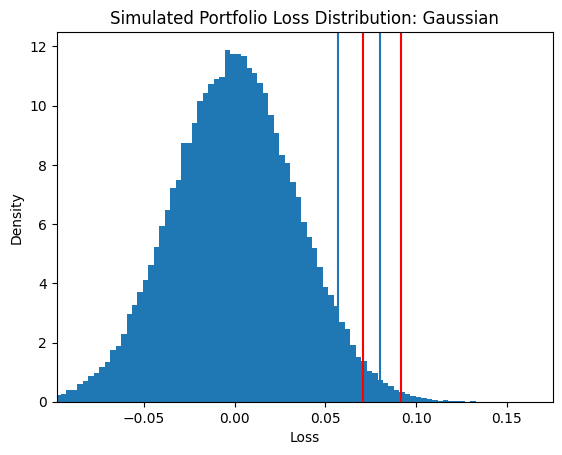

In [10]:
#plot: gaussian
plot_gaussian_pnl_distribution(sim_gaussian_port_returns, sim_t_port_returns, var_gaussian_95, var_gaussian_99, cvar_gaussian_95, cvar_gaussian_99)

In [11]:
print(np.std(sim_gaussian_port_returns))
print(np.mean(sim_gaussian_port_returns))

0.034372863249228926
-1.4511385371634881e-05


In [12]:
#returns: student-t
print(sim_t_asset_returns)
print(sim_t_port_returns)

[[-0.00655673 -0.01616991 -0.01748914 -0.00750842]
 [ 0.0985446   0.34513522 -0.04785706  0.01625021]
 [ 0.00192877  0.00230712 -0.02187142 -0.00616892]
 ...
 [ 0.00497179  0.03672518 -0.01478125 -0.00367106]
 [ 0.03636521  0.12066565  0.03177974  0.02440674]
 [-0.02583115 -0.15706649  0.08623865  0.03093106]]
[-0.01193105  0.10301825 -0.00595111 ...  0.00581117  0.05330434
 -0.01643198]


In [13]:
#risk metrics: student-t
#here difference between VaR and CVaR is a lot more noticeabe
var_t_95 = var(sim_t_port_returns, 0.95)
var_t_99 = var(sim_t_port_returns, 0.99)
cvar_t_95 = cvar(sim_t_port_returns, 0.95)
cvar_t_99 = cvar(sim_t_port_returns, 0.99)

var_t_95, var_t_99, cvar_t_95, cvar_t_99

(np.float64(0.06956470421980705),
 np.float64(0.1166118867341457),
 np.float64(0.09995350076840274),
 np.float64(0.15420552058468642))

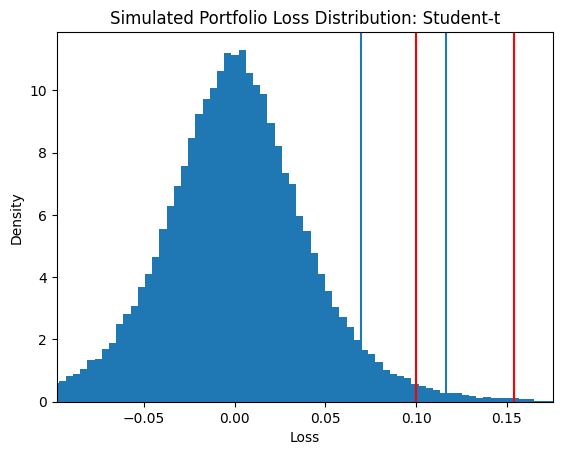

In [14]:
plot_t_pnl_distribution(sim_t_port_returns, sim_gaussian_port_returns, var_t_95, var_t_99, cvar_t_95, cvar_t_99)

In [15]:
print(np.std(sim_t_port_returns))
print(np.mean(sim_t_port_returns))

0.044384982704521965
-8.049098508717187e-05


In [16]:
#Backtesting

In [17]:
var_level = 0.99

breaches_gaussian, _ = backtest_var(rets, weights=weights, var_level=var_level, model='gaussian')
breaches_t, _ = backtest_var(rets, weights=weights, var_level=var_level, model='student-t')

In [18]:
#check gaussian breach rate
gaussian_empirical_rate = breaches_gaussian.mean()
gaussian_expected_rate = 1 - var_level

print(f'expected breach rate: {gaussian_expected_rate}')
print(f'empirical breach rate: {gaussian_empirical_rate}')

#kupiec test
gau_kup_LR, gau_kup_pval = kupiec_test(breaches_gaussian, var_level)
print(gau_kup_pval)


print(
    f"Gaussian Kupiec p-value = {gau_kup_pval:.3f}. "
    "At the 5% significance level, we fail to reject the null hypothesis of correct 99% VaR coverage."
)
print(
    "This indicates that incorporating EWMA volatility materially improves Gaussian VaR calibration, "
    "though tail risk remains less robustly modeled than under the Student-t specification."
)

expected breach rate: 0.010000000000000009
empirical breach rate: 0.0136986301369863
0.46136182249867985
Gaussian Kupiec p-value = 0.461. At the 5% significance level, we fail to reject the null hypothesis of correct 99% VaR coverage.
This indicates that incorporating EWMA volatility materially improves Gaussian VaR calibration, though tail risk remains less robustly modeled than under the Student-t specification.


In [19]:
#check student-t breach rate
t_empirical_rate = breaches_t.mean()
t_expected_rate = 1 - var_level

print(f'expected breach rate: {t_expected_rate}')
print(f'empirical breach rate: {t_empirical_rate}')

#kupiec test
t_kup_LR, t_kup_pval = kupiec_test(breaches_t, var_level)
print(t_kup_pval)

if t_kup_pval < 0.05:
    print(f'as kupiec p-value = {t_kup_pval} << 0.05, seeing breach results this extreme would only happen 0.8% of the time, which is too unlikely under the null')
    print('this suggests gaussian model has under-coverage (breaches occur too often relative to 1%), tail risk is underestimated, model fails backtest diagnostics')
else:
    print(
    f"Student-t Kupiec p-value = {t_kup_pval:.3f} vs Gaussian = {gau_kup_pval:.3f}. "
    "The higher p-value indicates breach frequencies are more consistent with nominal 99% VaR coverage under the Student-t model, "
    "suggesting better tail-risk calibration."
)

expected breach rate: 0.010000000000000009
empirical breach rate: 0.0091324200913242
0.8530743562890273
Student-t Kupiec p-value = 0.853 vs Gaussian = 0.461. The higher p-value indicates breach frequencies are more consistent with nominal 99% VaR coverage under the Student-t model, suggesting better tail-risk calibration.
